# Normalizing Depth to Euphotic Zone

Josie Donnelly

*Last updated 11.14.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random

import matplotlib.pyplot as plt
%matplotlib inline


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig.head(5)


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [3]:
# consider only the observations for which the target CHLA is available
df = df_orig[~df_orig['CHLA'].isna()].reset_index(drop=True)

# disregard all observations below 500m raw depth
df = df[df['PRES'] <= 500]

floats = np.unique(df['float'])
print(f'Number of unique floats: {len(floats)}')

df.head()


Number of unique floats: 565


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [4]:
# replace any negative CHLA value with 0
print('Initial counts:')
print(f'\tPositive CHLA values: {df[df["CHLA"]>0].shape[0]}')
print(f'\tNegative CHLA values: {df[df["CHLA"]<0].shape[0]}')
print(f'\tZero CHLA values: {df[df["CHLA"]==0].shape[0]}')

df.loc[df['CHLA'] < 0, 'CHLA'] = 0

print('\nAfter processing:')
print(f'\tPositive CHLA values: {df[df["CHLA"]>0].shape[0]}')
print(f'\tNegative CHLA values: {df[df["CHLA"]<0].shape[0]}')
print(f'\tZero CHLA values: {df[df["CHLA"]==0].shape[0]}')


Initial counts:
	Positive CHLA values: 16575831
	Negative CHLA values: 3130407
	Zero CHLA values: 40449

After processing:
	Positive CHLA values: 16575831
	Negative CHLA values: 0
	Zero CHLA values: 3170856


## Discribe estimation process and visualize CHLA dropoff for a few examples


Here is the procedure for estimating the bottom of the euphotic zone (refered to as the "euphotic floor"):

* Consider all CHLA values for each cycle of each float, ordered by raw depth (ascending)

* Define the peak to be the maximum CHLA value occurring at or above 250m of raw depth

* Starting at the depth corresponding to that peak or 75m (whichever is deeper), consider a rolling average of the next handful of CHLA values

* If the CHLA value at the depth considered is "close enough" to some near-zero error (chosen to be the maximum of these two values: the minimum CHLA value for the cycle, or 1% of the peak CHLA value for the cycle), consider this window to contain the smallest tolerable CHLA value.

* The depth corresponding to the smallest CHLA value in this window is taken as the euphotic floor.

* Discard all depths below the determined euphotic floor.

* Divide all depths in the cycle by the euphotic floor estimate to obtain the normalized depth.

Note that there are a handful of cycles that do not yield an estimate for the euphotic floor due to peaks at unreasonable depths, CHLA values never dropping near enough to zero, etc. These examples are discarded.

In [5]:
# function to obtain the minimum and maximum CHLA values of the desired with peak and depth limitations considered
def get_euphotic_floor_guess(cycle_df, err=0.01, window_size=10, verbose=0):
    # ensure cycle_df is ordered by ascending PRES value with index reset
    cycle_df = cycle_df.sort_values(by='PRES', ascending=True).reset_index(drop=True)
    
    if verbose > 0:
        print(f'Float-cycle: {cycle_df.loc[0,"float"]}-{cycle_df.loc[0,"cycleNumber"]}')
        print(f'Number of observations in cycle: {cycle_df.shape[0]}')
    
    # find the maximum CHLA value above 250m raw depth
    tmp_df = cycle_df[cycle_df['PRES'] <= 250].reset_index(drop=True)
    if tmp_df.shape[0] == 0:
        return None     # no observations above 250m; disregard cycle
    max_chla = max(tmp_df['CHLA'])
    if max_chla == 0:
        return None     # cycle contains only 0 (or previously negative) CHLA observations
    
    # find the index of this maximum CHLA value in the CHLA sequence
    max_chla_idx = list(cycle_df['CHLA']).index(max_chla)
    start_idx = cycle_df[cycle_df['PRES'] < 75].shape[0] + 1
    start_idx = max(start_idx, max_chla_idx)
    
    # find the minimum CHLA value after the peak or after 75m, whichever is deeper
    # recall that all CHLA values were processed to be nonnegative
    tmp_df = cycle_df.iloc[start_idx:].reset_index(drop=True)
    if tmp_df.shape[0] == 0:
        return None     # no observations after the peak; disregard cycle
    min_chla_after_peak = min(tmp_df['CHLA'])
    
    if verbose > 0:
        print(f'Peak: {max_chla:.4f}')
        print(f'Min after peak: {min_chla_after_peak:.4f}')
        
    # obtain estimate for bottom of euphotic zone
    euphotic_floor_guess = None
    chla_thresh = max(min_chla_after_peak, 0.01*(max_chla-min_chla_after_peak))
    
    while max_chla <= err:
        err /= 100     # decrease error for cycles with abnormally small CHLA values

    for i in range(tmp_df.shape[0]):
        window_df = tmp_df.loc[i:i+window_size]
        if np.mean(window_df['CHLA']) - chla_thresh < err:
            min_chla = min(window_df['CHLA'])
            euphotic_floor_guess = window_df[window_df['CHLA']==min_chla].reset_index(drop=True).loc[0,'PRES']
            break
    
    if verbose > 0:
        if euphotic_floor_guess is None:
            unit = ''
        else:
            unit='m'
        print(f'Euphotic floor estimate: {euphotic_floor_guess}{unit}')
        
    return euphotic_floor_guess
    

In [6]:
# function to plot a path of a float cycle on a map, colored by raw depth (PRES) by default
def plot_on_map(tmp_df, color_by='PRES', cmap='plasma_r', figsize=(10,4), title=None):
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    land.plot(color='lightgray', figsize=figsize)
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], c=tmp_df[color_by], cmap=cmap, s=1, alpha=0.7)
    cbar = plt.colorbar(label=color_by)
    cbar.ax.invert_yaxis()
    if title is None:
        plt.title(f'Cycle {tmp_df.loc[0,"cycleNumber"]} of Float {tmp_df.loc[0,"float"]}')
    else:
        plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    plt.show()
    

In [7]:
def plot_chla_dropoff(cycle_df, euphotic_floor_guess, figsize=(16,6)):
    plt.plot(cycle_df['PRES'], cycle_df['CHLA'])
    if euphotic_floor_guess is not None:
        plt.axvline(x=euphotic_floor_guess, color='r')
    plt.title(f'CHLA Dropoff for Cycle {cycle_df.loc[0,"cycleNumber"]} of Float {cycle_df.loc[0,"float"]}')
    plt.xlabel('raw depth')
    plt.ylabel('CHLA')
    
    plt.show()
    

Float-cycle: 5904842-154
Number of observations in cycle: 281
Peak: 0.3672
Min after peak: 0.0000
Euphotic floor estimate: 228m


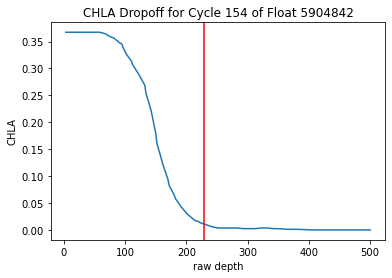

Float-cycle: 5906340-34
Number of observations in cycle: 279
Peak: 0.1092
Min after peak: 0.0000
Euphotic floor estimate: 220m


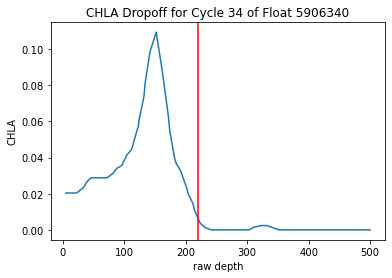

Float-cycle: 6903070-32
Number of observations in cycle: 471
Peak: 0.1424
Min after peak: 0.0000
Euphotic floor estimate: 204m


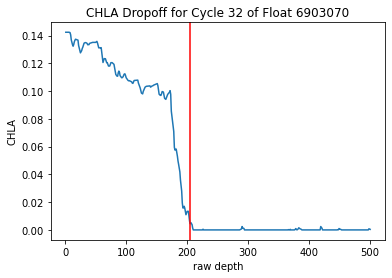

In [8]:
# plot path on map and CHLA dropoff for a random float-cycle
num = 3
err = 0.01
window_size = 5
for i in range(num):
    euphotic_floor_guess = None
    f = random.choice(floats)
    float_df = df[df['float'] == f]
    cycles = np.unique(float_df['cycleNumber'])
    c = random.choice(cycles)
    cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
    euphotic_floor_guess = get_euphotic_floor_guess(cycle_df, err=err, window_size=window_size, verbose=1)

    # visualize the guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
    # plot_on_map(cycle_df)


Float-cycle: 6903550-117
Number of observations in cycle: 410
Peak: 0.0073
Min after peak: 0.0000
Euphotic floor estimate: 76m


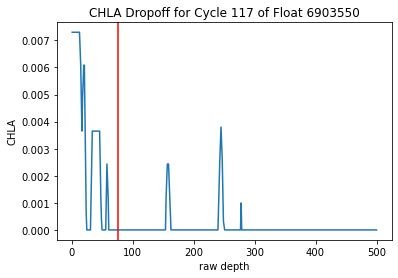

Float-cycle: 6902735-352
Number of observations in cycle: 486
Peak: 0.1812
Min after peak: 0.0000
Euphotic floor estimate: 179m


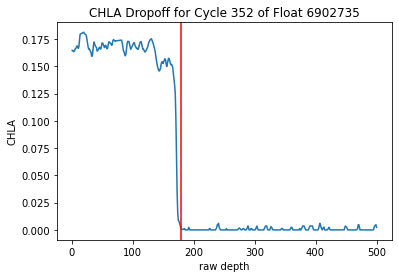

Float-cycle: 6901180-238
Number of observations in cycle: 480
Peak: 0.7869
Min after peak: 0.0000
Euphotic floor estimate: 178m


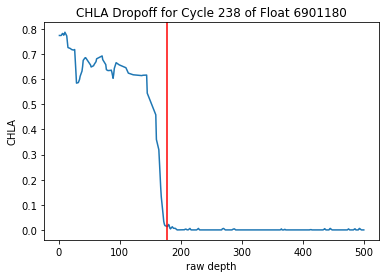

In [9]:
# plot for known odd cycles
num = 3
err = 0.01
odd_float_cycles = [(6903550, 117), (6902735, 352), (6901180, 238)]
window_size = 5
for i in range(num):
    euphotic_floor_guess = None
    f, c = odd_float_cycles[i]
    float_df = df[df['float'] == f]
    cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
    euphotic_floor_guess = get_euphotic_floor_guess(cycle_df, err=err, window_size=window_size, verbose=1)

    # visualize the guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
    # plot_on_map(cycle_df)
    

## Obtain euphotic floor estimates

In [10]:
# obtain bottom of euphotic zone estimates for all cycles
err = 0.01
window_size = 5

# initialize dataframe for invalid results
floor_not_found_df = pd.DataFrame(columns=['float', 'cycle', 'guess'])

# initialize dataframe to keep results
normalized_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
normalized_df


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,normalized_depth,sat_adg_s,sat_bbp_s


In [11]:
verbose = 0
for num, f in enumerate(floats):
    float_df = df[df['float'] == f]
    cycles = np.unique(float_df['cycleNumber'])
    if verbose > 0:
        print(f'{num:<3} float {f:<9} ({len(cycles)} cycles)')
    
    float_results_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
    
    for c in cycles:
        euphotic_floor_guess = None
    
        cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
        euphotic_floor_guess = get_euphotic_floor_guess(cycle_df, err=err, window_size=window_size, verbose=0)

        if euphotic_floor_guess is None:
            # guess is invalid
            floor_not_found_df.loc[floor_not_found_df.shape[0]] = [f, c, euphotic_floor_guess]
            if verbose > 1:
                print(f'\tRetry: float {f}, cycle {c}')
            continue

        # else, guess is valid; normalize and add results to dataframe
        cycle_df = cycle_df[cycle_df['PRES'] <= euphotic_floor_guess]
        # note: normalization does not risk division by 0 because only depths beyond 75m are considered
        cycle_df.insert(loc=list(cycle_df.columns).index('PRES')+1, column='normalized_depth', value=[d/euphotic_floor_guess for d in cycle_df['PRES']])
        float_results_df = pd.concat([float_results_df, cycle_df])
        
    if float_results_df.shape[0] > 0:
        # if this float yielded results, add to final dataframe
        normalized_df = pd.concat([normalized_df, float_results_df])
        

In [12]:
normalized_df = normalized_df.reset_index(drop=True)
normalized_df


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,normalized_depth,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.012931,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.017241,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.025862,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.034483,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.043103,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304851,7901001,17.330,-23.271,28,2022-05-23 11:34:00,155,35.801467,15.528111,0.000313,0.014600,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.974843,0.018,1.906093
8304852,7901001,17.330,-23.271,28,2022-05-23 11:34:00,156,35.795858,15.489444,0.000313,0.013557,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.981132,0.018,1.906093
8304853,7901001,17.330,-23.271,28,2022-05-23 11:34:00,157,35.790250,15.450777,0.000315,0.012949,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.987421,0.018,1.906093
8304854,7901001,17.330,-23.271,28,2022-05-23 11:34:00,158,35.785941,15.418611,0.000316,0.012340,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.993711,0.018,1.906093


In [16]:
# confirm that there are no missing normalized_depth values
normalized_df.isna().sum()


float                     0
latitude                  0
longitude                 0
cycleNumber               0
date                      0
PRES                      0
PSAL                 187493
TEMP                   2170
BBP700                 4419
CHLA                      0
short_date                0
sat_chl             1214750
sat_ipar            1484040
sat_sst              340260
sat_poc             1214750
sat_bbp_443         1226234
sat_a_678           1226234
sat_kd_490          1214750
sat_nflh            1484040
sat_pic             1313841
sat_Rrs_678         1214750
sat_aph_443         1226234
sat_par              114733
sat_angstrom        1214750
sat_bb_678          1226234
sat_adg_443         1226234
sat_aot_869         1214750
normalized_depth          0
sat_adg_s           1226234
sat_bbp_s           1226234
dtype: int64

## Analyze the results

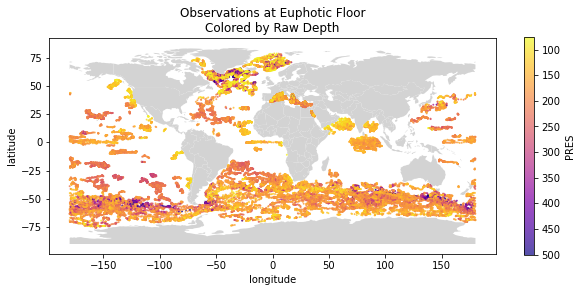

In [13]:
# display the observations colored by the depth of the euphotic floor
euphotic_floor_df = normalized_df[normalized_df['normalized_depth']==1.0].reset_index(drop=True)
plot_on_map(euphotic_floor_df, color_by='PRES', title='Observations at Euphotic Floor\nColored by Raw Depth')


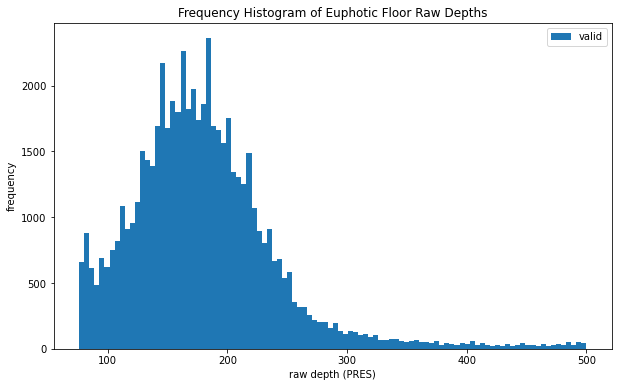

In [14]:
# display a frequency histogram of euphotic floor depths; invalid depths included
plt.figure(figsize=(10,6))
plt.hist(euphotic_floor_df['PRES'], bins=100)
plt.title('Frequency Histogram of Euphotic Floor Raw Depths')
plt.xlabel('raw depth (PRES)')
plt.ylabel('frequency')
plt.legend()
plt.show()


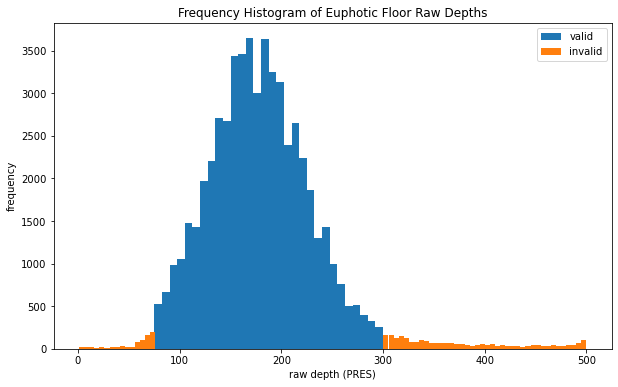

In [55]:
# results with slightly different prodecure when floors <75m and >300m were considered invalid

In [15]:
# check the number of "invalid" cycles for which the euphotic floor is found to be above 75m or below 300m
up_lim = 75
lo_lim = 300
invalid_euphotic_floors_df = euphotic_floor_df[(euphotic_floor_df['PRES'] < up_lim) | (euphotic_floor_df['PRES'] > lo_lim)].reset_index(drop=True)
print(f'Number of "invalid" cycles: {invalid_euphotic_floors_df.shape[0]}')


Number of "invalid" cycles: 2407


## View a few ambiguous cycles

In [17]:
print(f'Number of cycles for which a valid euphotic floor estimate was not found: {floor_not_found_df.shape[0]}')


Number of cycles for which a valid euphotic floor estimate was not found: 187


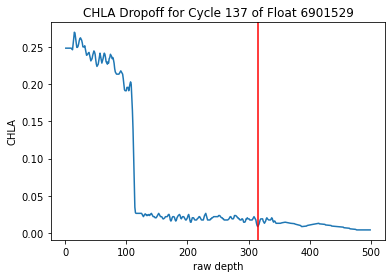

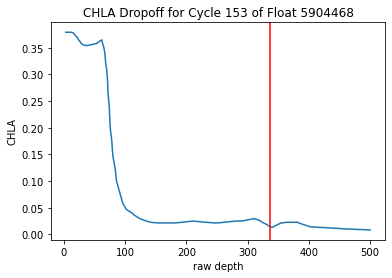

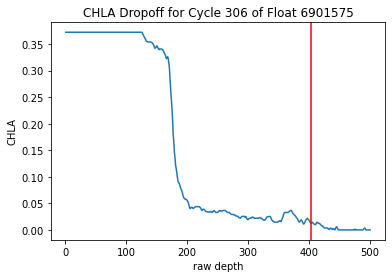

In [19]:
# view a few examples for which the euphotic floor is out of the bounds specified above
num = 3
for i in range(3):
    f = random.choice(invalid_euphotic_floors_df['float'])
    invalid_float_df = invalid_euphotic_floors_df[invalid_euphotic_floors_df['float']==f]
    c = random.choice(np.unique(invalid_float_df['cycleNumber']))
    cycle_df = df[(df['float']==f) & (df['cycleNumber']==c)].reset_index(drop=True)
    euphotic_floor_guess = invalid_float_df[invalid_float_df['cycleNumber']==c].reset_index(drop=True).loc[0,'PRES']

    # visualize the guess; these examples should have no guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
#     plot_on_map(cycle_df)


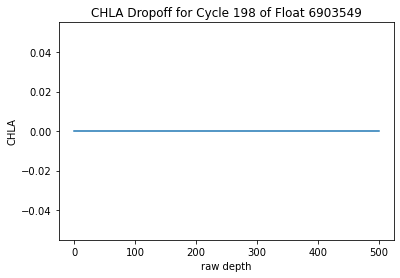

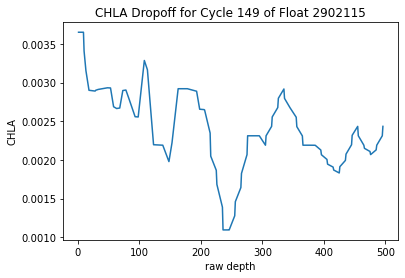

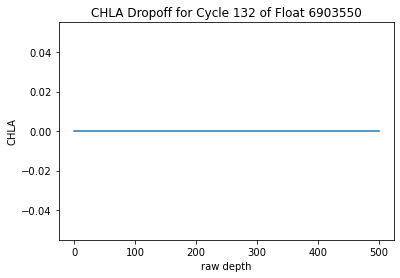

In [21]:
# view a few examples for which the euphotic floor is None
num = 3
for i in range(3):
    f = random.choice(floor_not_found_df['float'])
    invalid_float_df = floor_not_found_df[floor_not_found_df['float']==f]
    c = random.choice(np.unique(invalid_float_df['cycle']))
    cycle_df = df[(df['float']==f) & (df['cycleNumber']==c)].reset_index(drop=True)

    # visualize the guess; these examples should have no guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=None)
#     plot_on_map(cycle_df)


## Finalize and save the dataframe

In [22]:
# add a column for the day of the year in radians
normalized_df.insert(loc=list(normalized_df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in normalized_df['date']])

# ensure the rows of the dataframe are unique
assert(normalized_df.shape[0] == normalized_df.drop_duplicates().shape[0])

# save the dataframe
# note that the "invalid" cycles are NOT included in the results;
# further investigation is required into these examples before estimating the euphotic floor
result_path = path + 'results/'
result_file = 'float_sat_normalized_depth.csv'
normalized_df.to_csv(result_path + result_file, index=False)

normalized_df


,float,latitude,longitude,cycleNumber,date,day_of_year_rad,PRES,PSAL,TEMP,BBP700,...,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,normalized_depth,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,3,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.012931,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,4,35.539001,12.378333,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.017241,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,6,35.539001,12.378667,0.001788,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.025862,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,8,35.539001,12.379000,0.001789,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.034483,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2.167505,10,35.539001,12.379000,0.001790,...,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.043103,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304851,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2.459947,155,35.801467,15.528111,0.000313,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.974843,0.018,1.906093
8304852,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2.459947,156,35.795858,15.489444,0.000313,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.981132,0.018,1.906093
8304853,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2.459947,157,35.790250,15.450777,0.000315,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.987421,0.018,1.906093
8304854,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2.459947,158,35.785941,15.418611,0.000316,...,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.993711,0.018,1.906093


In [24]:
# save information about invalid cycles
floor_not_found_file = 'euphotic_floor_estimate_not_found.csv'
floor_not_found_df.to_csv(result_path + floor_not_found_file, index=False)

floor_not_found_df


,float,cycle,guess
0,2902115.0,127.0,NaN
1,2902115.0,128.0,NaN
2,2902115.0,129.0,NaN
3,2902115.0,130.0,NaN
4,2902115.0,132.0,NaN
...,...,...,...
182,6903555.0,60.0,NaN
183,6903568.0,46.0,NaN
184,6903568.0,54.0,NaN
185,6903568.0,56.0,NaN
